In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datasets import get_datasets, get_shiller
import matplotlib.pyplot as plt
import random

time_horizon = 40

data = get_datasets()
data['returns_with_dividends'] = data['simple_return'] + data['dividend_return']

[*********************100%***********************]  1 of 1 completed


In [44]:
# Define the investment horizon in months
time_horizon_months = 360

# Define the horizons and the number of portfolios
horizons = np.arange(1, time_horizon_months+1, 1)
n_portfolios = len(data) - time_horizon_months + 1

cum_risk_free_returns_distributions = np.zeros((len(horizons), n_portfolios))
cum_dividends_returns_distributions = np.zeros((len(horizons), n_portfolios))
starting_dates = []
# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):

    # Loop through each portfolio and calculate the cumulative returns
    for i in range(n_portfolios):
        start_idx = i
        end_idx = start_idx + horizon

        risk_free_returns = data.loc[start_idx:end_idx-1, 'returns_rf'].values
        dividends_returns = data.loc[start_idx:end_idx-1, 'returns_with_dividends'].values

        cum_risk_free_returns_portfolios = np.prod(1 + risk_free_returns) - 1
        cum_dividends_returns_portfolios = np.prod(1 + dividends_returns) - 1

        # Convert the cumulative returns into annualized returns
        annualized_risk_free_returns_portfolios = (1 + cum_risk_free_returns_portfolios)**(12/horizon) - 1
        annualized_dividends_returns_portfolios = (1 + cum_dividends_returns_portfolios)**(12/horizon) - 1

        cum_risk_free_returns_distributions[h_idx, i] = annualized_risk_free_returns_portfolios
        cum_dividends_returns_distributions[h_idx, i] = annualized_dividends_returns_portfolios


773


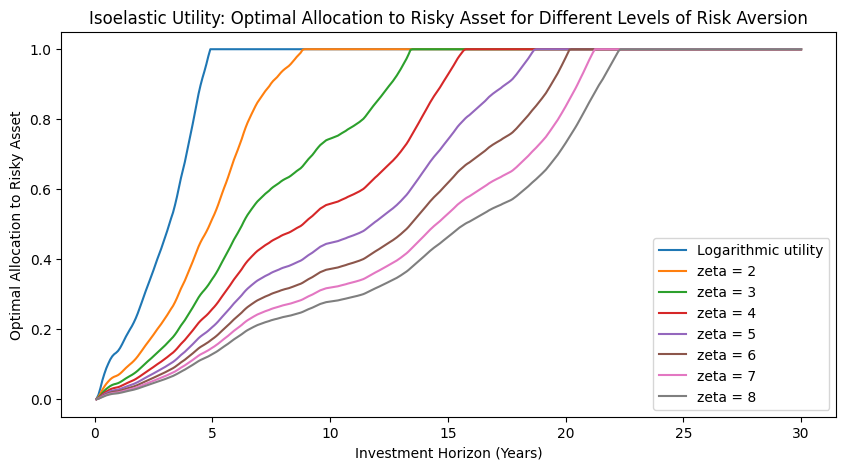

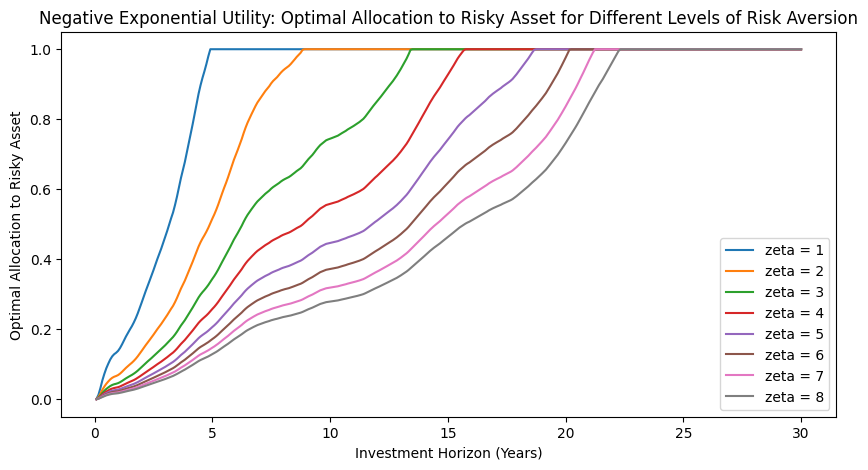

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns.

    Parameters:
    - risky_returns: A numpy array of risky asset returns
    - risk_free_returns: A numpy array of risk-free asset returns
    - zeta: The degree of risk aversion
    - periods_in_year: The number of periods in a year (12 for monthly returns, 250 for daily returns)

    Returns:
    - w: The optimal allocation to the risky asset
    """
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    # Clip allocation to [0,1]
    w = np.clip(w, 0, 1)

    return w

# Isoelastic and Logarithmic utility plot
zetas = range(1, 9)  # Include zeta=1 for logarithmic utility
allocations = []
for zeta in zetas:
    allocations_zeta = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        w = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta)
        allocations_zeta.append(w)
    allocations.append(allocations_zeta)

labels = ['Logarithmic utility'] + [f'zeta = {zeta}' for zeta in zetas[1:]]
plt.figure(figsize=(10, 5))
for i, label in enumerate(labels):
    plt.plot(range(1, 361), allocations[i], label=label)
plt.legend()
plt.xticks(range(0, 361, 60), range(0, 31, 5))  # Show every fifth year on the x-axis
plt.xlabel('Investment Horizon (Years)')
plt.ylabel('Optimal Allocation to Risky Asset')
plt.title('Isoelastic Utility: Optimal Allocation to Risky Asset for Different Levels of Risk Aversion')
plt.show()

# Negative Exponential utility plot
def calculate_exponential_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation
    w = (mu - rf) / (zeta * sigma**2)  # Negative exponential utility
    w = np.clip(w, 0, 1)  # Clip allocation to [0,1]
    return w

zetas_exp = range(1, 9)  # For negative exponential utility
allocations_exp = []
for zeta in zetas_exp:
    allocations_zeta = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        w = calculate_exponential_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta)
        allocations_zeta.append(w)
    allocations_exp.append(allocations_zeta)

plt.figure(figsize=(10, 5))
for zeta, allocation in zip(zetas_exp, allocations_exp):
    plt.plot(range(1, 361), allocation, label=f'zeta = {zeta}')
plt.legend()
plt.xticks(range(0, 361, 60), range(0, 31, 5))  # Show every fifth year on the x-axis
plt.xlabel('Investment Horizon (Years)')
plt.ylabel('Optimal Allocation to Risky Asset')
plt.title('Negative Exponential Utility: Optimal Allocation to Risky Asset for Different Levels of Risk Aversion')
plt.show()


In [46]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns.

    Parameters:
    - risky_returns: A numpy array of risky asset returns
    - risk_free_returns: A numpy array of risk-free asset returns
    - zeta: The degree of risk aversion
    - periods_in_year: The number of periods in a year (12 for monthly returns, 250 for daily returns)

    Returns:
    - w: The optimal allocation to the risky asset
    - p_value: The p-value from the horizon invariance test
    """

    # Original calculation
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    # Clip allocation to [0,1]
    w = np.clip(w, 0, 1)

    # Horizon invariance test
    horizon_weights = []
    for horizon in [1, 5, 10]:
        horizon_risky_returns = risky_returns[:horizon]
        horizon_rf_returns = risk_free_returns[:horizon]
        horizon_w = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns, horizon_rf_returns, zeta, periods_in_year)
        horizon_weights.append(horizon_w)

    diff_weights = np.array(horizon_weights[1:]) - horizon_weights[0]  # Calculate differences in weights
    p_value = (diff_weights < 0).sum() / float(len(diff_weights))  # Calculate p-value

    return w, p_value

def calculate_optimal_allocation_annualized_no_test(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    """
    Calculate the optimal allocation to the risky asset with annualized returns, without performing the horizon invariance test.

    Parameters and Returns:
    - Same as calculate_optimal_allocation_annualized()
    """
    mu = np.mean(risky_returns)
    rf = np.mean(risk_free_returns)
    sigma = np.std(risky_returns) * np.sqrt(periods_in_year)  # Annualize the standard deviation

    if zeta == 1:  # Logarithmic utility
        w = (mu - rf) / sigma**2
    else:  # Isoelastic utility
        w = (mu - rf) / (zeta * sigma**2)

    w = np.clip(w, 0, 1)

    return w

# Isoelastic and Logarithmic utility plot
zetas = range(1, 9)  # Include zeta=1 for logarithmic utility
allocations = []
p_values = []
for zeta in zetas:
    allocations_zeta = []
    p_values_zeta = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        w, p_value = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta)
        allocations_zeta.append(w)
        p_values_zeta.append(p_value)
    allocations.append(allocations_zeta)
    p_values.append(p_values_zeta)

print(p_values)


/var/folders/p_/sj7lt16104lck02ntqq_6pjm0000gn/T/ipykernel_6720/2097755510.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  w = (mu - rf) / sigma**2
/var/folders/p_/sj7lt16104lck02ntqq_6pjm0000gn/T/ipykernel_6720/2097755510.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  w = (mu - rf) / (zeta * sigma**2)


[[1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [55]:
import numpy as np
from scipy.stats import ttest_ind

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, i, periods_in_year=12):
    # Updated calculation
    if zeta == 1:  # Logarithmic utility
        w = (risky_returns - risk_free_returns) / risky_returns.std()**2
    else:  # Isoelastic utility
        w = (risky_returns - risk_free_returns) / (zeta * risky_returns.std()**2)

    # Calculate p-value for horizon = 5
    horizon_risky_returns_5 = cum_dividends_returns_distributions[59]  
    horizon_rf_returns_5 = cum_risk_free_returns_distributions[12]  
    horizon_w_5 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_5, horizon_rf_returns_5, zeta, periods_in_year)
    _, p_value_5 = ttest_ind(w, horizon_w_5)  # Calculate p-value for horizon = 5

    # Calculate p-value for horizon = 10
    horizon_risky_returns_10 = cum_dividends_returns_distributions[119]  
    horizon_rf_returns_10 = cum_risk_free_returns_distributions[119]  
    horizon_w_10 = calculate_optimal_allocation_annualized_no_test(horizon_risky_returns_10, horizon_rf_returns_10, zeta, periods_in_year)
    _, p_value_10 = ttest_ind(w, horizon_w_10)  # Calculate p-value for horizon = 10

    return w, [p_value_5, p_value_10]


def calculate_optimal_allocation_annualized_no_test(risky_returns, risk_free_returns, zeta, periods_in_year=12):
    if zeta == 1:  # Logarithmic utility
        w = (risky_returns - risk_free_returns) / risky_returns.std()**2
    else:  # Isoelastic utility
        w = (risky_returns - risk_free_returns) / (zeta * risky_returns.std()**2)

    return w

# Isoelastic and Logarithmic utility plot
zetas = [1,2,4,6,8]  # Include zeta=1 for logarithmic utility
horizons = [0,5,11,17,23,29,35,41,47,53,59]

p_value_table = []


for zeta in zetas:
    row = []

    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        if(i in horizons):
            allocation, p_values = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta, i)
            row.append(np.clip(np.mean(allocation)*100,0,100))  # Append the mean allocation

            if i == 0:
                save = p_values  # Save the p-values for the first observation

    row.extend(save)  # Append the saved p-values outside the inner loop
    p_value_table.append(row)  # Append the row to the table outside the inner loop

# Generate LaTeX table
table = "\\begin{table}[ht]\n"
table += "\\centering\n"
table += "\\caption{Optimal Allocations and P-Values}\n"
table += "\\begin{tabular}{|c|" + "|".join(["c" for _ in range(len(horizons) + 2)]) + "|}\n"
table += "\\hline\n"
table += " & ".join(["Zeta"] + [f"{h+1}M" for h in horizons] + ["1mv5 p-value", "1mv10 p-value"]) + " \\\\\n"
table += "\\hline\n"

for i, zeta in enumerate(zetas):
    table += f"{zeta} & "
    for j in range(len(horizons)):
        table += f"{p_value_table[i][j]:.2f}\% & "
    table += f"{p_value_table[i][-2]:.2f} & {p_value_table[i][-1]:.2f} \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\end{table}"

print(table)



\begin{table}[ht]
\centering
\caption{Optimal Allocations and P-Values}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
Zeta & 1M & 6M & 12M & 18M & 24M & 30M & 36M & 42M & 48M & 54M & 60M & 1mv5 p-value & 1mv10 p-value \\
\hline
1 & 1.45\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 1.00 & 1.00 \\
2 & 0.73\% & 53.18\% & 82.99\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 1.00 & 1.00 \\
4 & 0.36\% & 26.59\% & 41.50\% & 59.75\% & 82.83\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 1.00 & 1.00 \\
6 & 0.24\% & 17.73\% & 27.66\% & 39.84\% & 55.22\% & 73.68\% & 92.55\% & 100.00\% & 100.00\% & 100.00\% & 100.00\% & 1.00 & 1.00 \\
8 & 0.18\% & 13.29\% & 20.75\% & 29.88\% & 41.42\% & 55.26\% & 69.41\% & 86.81\% & 100.00\% & 100.00\% & 100.00\% & 1.00 & 1.00 \\
\hline
\end{tabular}
\end{table}


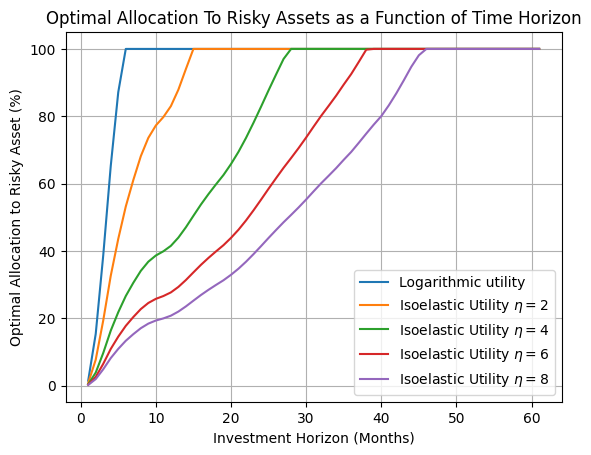

In [58]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

def calculate_optimal_allocation_annualized(risky_returns, risk_free_returns, zeta, i, periods_in_year=12):
    # Updated calculation
    if zeta == 1:  # Logarithmic utility
        w = (risky_returns - risk_free_returns) / risky_returns.std()**2
    else:  # Isoelastic utility
        w = (risky_returns - risk_free_returns) / (zeta * risky_returns.std()**2)

    return w

# Isoelastic and Logarithmic utility plot
zetas = [1,2,4,6,8]  # Include zeta=1 for logarithmic utility

p_value_table = []

for zeta in zetas:
    row = []
    for i, risky_returns in enumerate(cum_dividends_returns_distributions):
        if(i < 61):
            allocation = calculate_optimal_allocation_annualized(risky_returns, cum_risk_free_returns_distributions[i], zeta, i)
            row.append(np.clip(np.mean(allocation)*100,0,100))  # Append the mean allocation
    p_value_table.append(row)  # Append the row to the table outside the inner loop

# Create a plot for each zeta
for i, zeta in enumerate(zetas):
    allocations = p_value_table[i]
    if zeta == 1:
        plt.plot(range(1, 62), allocations, label='Logarithmic utility')
    else:
        plt.plot(range(1, 62), allocations, label=f'Isoelastic Utility $\\eta={zeta}$')  # Use LaTeX format for Greek letter zeta

# Set plot title and labels
plt.title('Optimal Allocation To Risky Assets as a Function of Time Horizon')
plt.xlabel('Investment Horizon (Months)')
plt.ylabel('Optimal Allocation to Risky Asset (%)')
plt.grid()

# Add a legend
plt.legend()

# Show the plot
plt.savefig('portfolios/utility')
plt.show()
